## Simulating LSST-like image time-series of lensed type Ia supernovae

### Import python libraries, LSST characteristics and functions

In [1]:
import pickle as pickle
from class_telescope import Telescope
from image_time_series import simulate_time_series_images
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Parameter distributions 

Sample $z_l$, $z_s$ and $\theta_E$ from MC sample from Wojtak et al. (2019).


0.05001794208436581


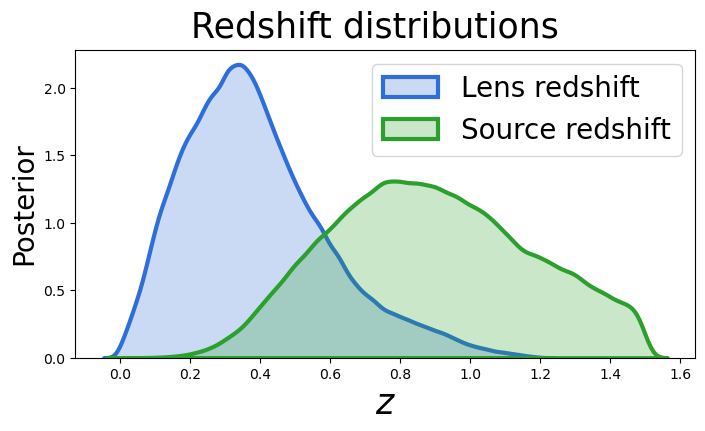

In [2]:
# ---------------------------------
telescope = 'LSST'
bandpasses = ['r', 'i', 'z', 'y']
# ---------------------------------

lsst = Telescope(telescope, bandpasses)

z_source_list_, z_lens_list_, theta_E_list_ = lsst.load_z_theta(theta_min=0.05)
print(min(theta_E_list_))

lsst.plot_redshifts(z_lens_list_, z_source_list_)

### Seeing distributions
Sample the PSF from the predicted seeing distribution for the <b> baseline v2.0 </b> observing strategy for 10 years.

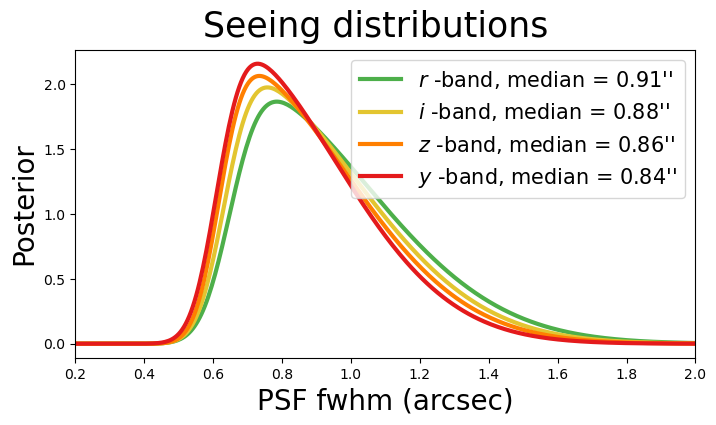

In [3]:
lsst.plot_seeing_distributions()


### Cadence

Sample the cadence from the predicted distribution for the <b> baseline v2.0 </b> observing strategy for the LSST Wide, Fast, Deep survey from Catarina Alves' simulations.


100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 710.19it/s]


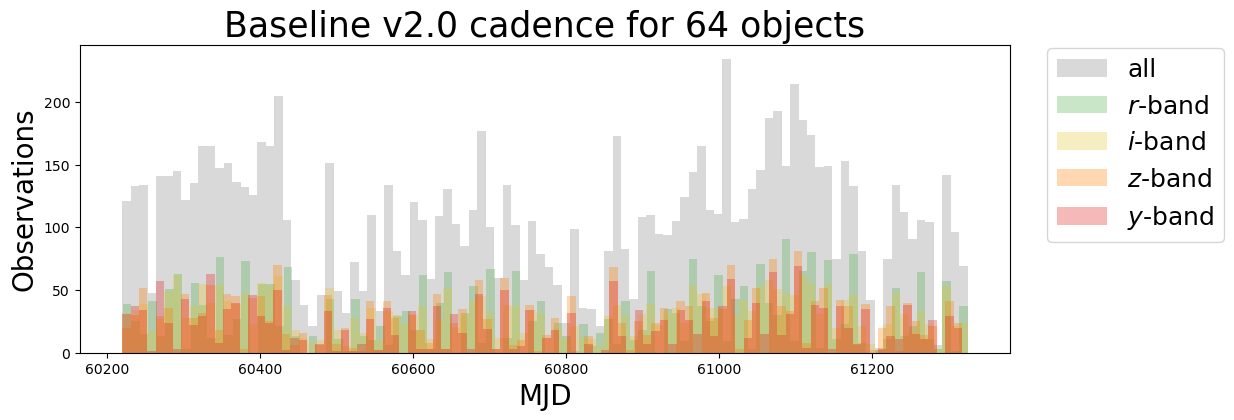

In [4]:
obs_times, obs_filters = lsst.load_cadence(small_sample=True)

obs_all, obs_r, obs_i, obs_z, obs_y = lsst.get_total_obs_times(obs_times, obs_filters)

lsst.plot_cadence(obs_times, obs_all, obs_r, obs_i, obs_z, obs_y)

### Generation of training and test sets


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Theoretically visible with image multiplicity method?            True
Theoretically visible with magnification method?                 True
Observations allow for detection with image multiplicity method? True
Observations allow for detection with magnification method?      True
 
Lens redshift:  0.27
Supernova redshift:  0.77
Einstein radius:  0.72
Time delays:  [0.   3.03 7.04 8.21] days
Macro magnification:  [2.59 3.09 1.63 1.39]
Microlensing contribution at peak (magnitudes):  0.0
Hubble constant:  67.8
Time-delay distance:  1872.98
Peak brightness images for r,i,z,y bands:
[[23.03 23.02 23.56 23.7 ]
 [22.32 22.15 22.82 23.  ]
 [22.49 22.3  23.   23.17]
 [22.45 22.25 22.97 23.16]]
 


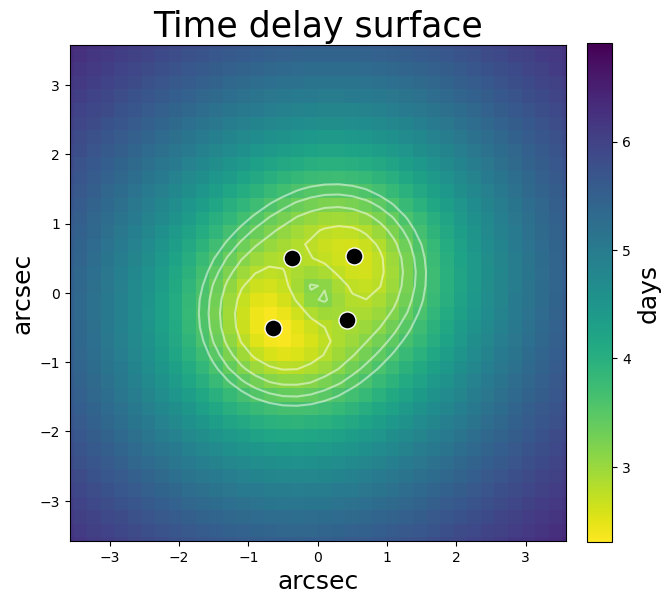

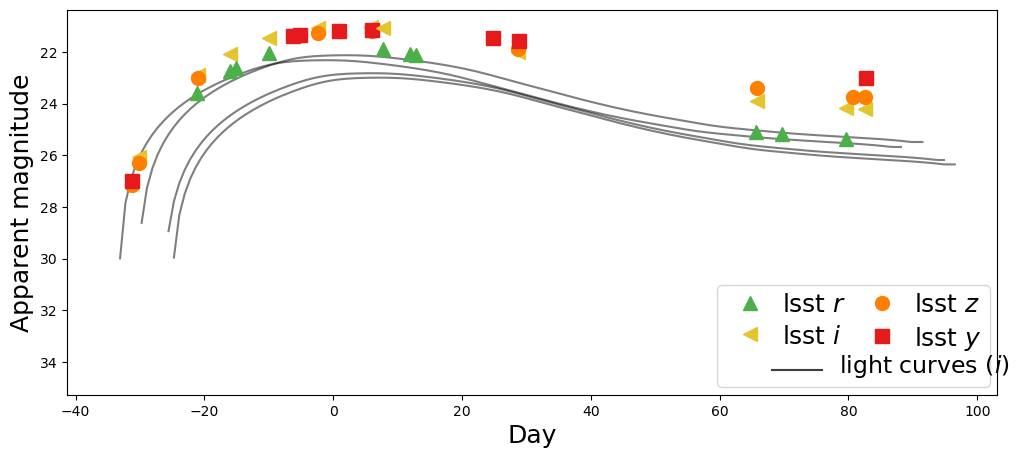

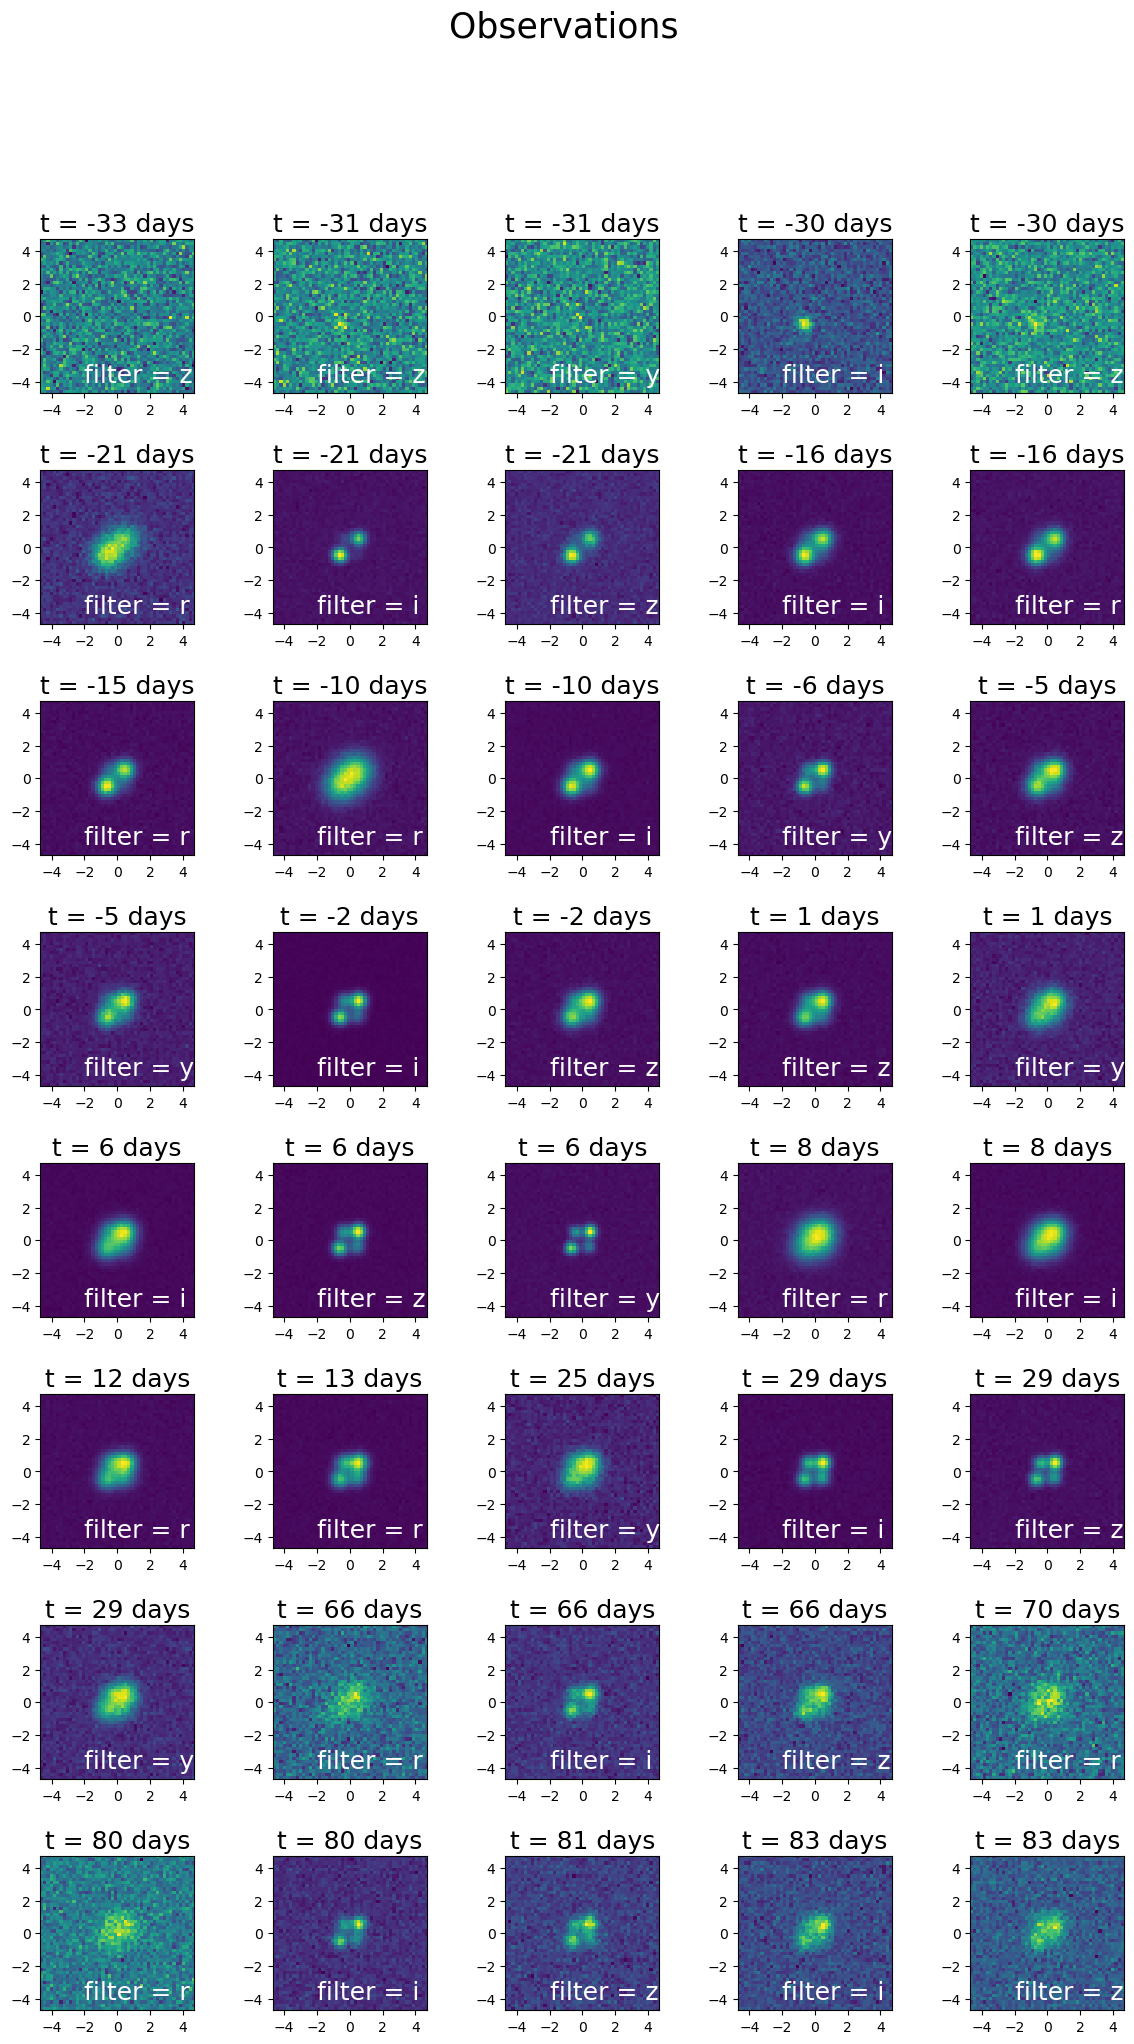

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.33s/it]

Done!
Simulating images took  7.0 seconds ( 0.0 hours) to complete.
Number of image-time series generated:  1
Number of configurations tried:  6
Number of attempts:  1463
 


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.97s/it]

                                         time_series  z_source    z_lens  \
0  [[[0.9026056637708724, 0.4788255949844051, -0....  0.771509  0.270876   

     H0   theta_E                                           obs_peak  \
0  67.8  0.715551  [[23.03473290479153, 23.018926939818343, 23.55...   

                                           obs_times  \
0  [-33.01948023351724, -31.276280233520083, -31....   

                                           obs_bands  \
0  [z, z, y, i, z, r, i, z, i, r, r, r, i, y, z, ...   

                                       brightness_im  \
0  [[inf, 1.7976931348623157e+308, 1.797693134862...   

                               brightness_unresolved  ... micro_peak  \
0  [nan, 27.036059225140157, 26.928884555901853, ...  ...        0.0   

    stretch    colour         Mb   obs_start     obs_end mult_method_peak  \
0  0.482678 -0.051373 -19.670487  60390.4107  60506.0924             True   

   mult_method  mag_method_peak  mag_method  
0         True   

In [11]:
num_samples = 1               # Total number of lens systems to be generated  
batch_size = 1                # Number of lens systems that is saved together in a batch
batch = 1                     # Starting number of the batch
num_images = 4                # Choose between 2 (for doubles) and 4 (for quads)
obs_upper_limit = 100         # Upper limit of number of observations
obs_lower_limit = 5           # Lower limit of number of observations
fixed_H0 = True               # Bool, if False: vary H0. if True: fix H0 to 70 km/s/Mpc (for the evaluation set)
add_microlensing = False      # Bool, if False: Only macro magnification. if True: Add effects of microlensing

Show = True                   # Bool, if True: Show figures and print information about the lens systems
Save = False                  # Bool, if True: Save image time-series
path = "../processed_data/Baseline_v_2_0_/" # Path to folder in which to save the results


df = simulate_time_series_images(batch_size, batch,  num_samples, num_images, obs_times,
                                                 obs_filters, obs_all, z_source_list_, z_lens_list_, theta_E_list_, 
                                                 add_microlensing, telescope, bandpasses, 
                                                 obs_lower_limit, obs_upper_limit, fixed_H0, Show, Save, path)


### Retrieve light curve observations

22.905365021204794
30.96020000000135
30.96020000000135
8
[1.79769313e+308]


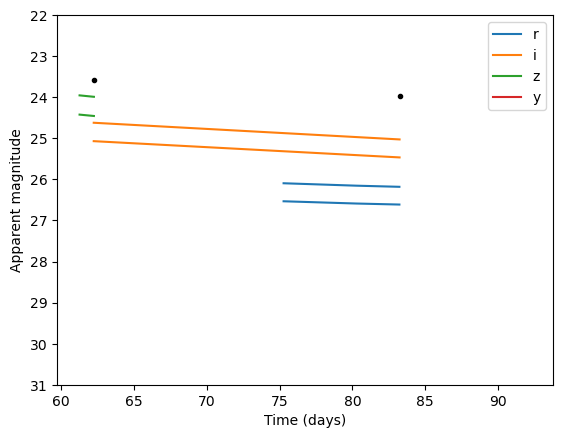

In [6]:
print(min(df['brightness_unresolved'][0]))


times = np.array(df['obs_times'][0])
bands = np.array(df['obs_bands'][0])
mags = df['brightness_im'][0]
mags_unresolved = df['brightness_unresolved'][0]

print(times[-1] - times[0])
print(df['obs_end'][0] - df['obs_start'][0])
print(len(times))

mask_r = np.where(bands == 'r')
mask_i = np.where(bands == 'i')
mask_z = np.where(bands == 'z')
mask_y = np.where(bands == 'y')

print(df['brightness_im'][0][:,1][mask_y])

plt.figure()
plt.plot(times[mask_r], mags[:,0][mask_r], color='C0', label="r")
plt.plot(times[mask_r], mags[:,1][mask_r], color='C0')

plt.plot(times[mask_i], mags[:,0][mask_i], color='C1', label="i")
plt.plot(times[mask_i], mags[:,1][mask_i], color='C1')
plt.plot(times[mask_i], mags_unresolved[mask_i], '.', color='black')

plt.plot(times[mask_z], mags[:,0][mask_z], color='C2', label="z")
plt.plot(times[mask_z], mags[:,1][mask_z], color='C2')

plt.plot(times[mask_y], mags[:,0][mask_y], color='C3', label="y")
plt.plot(times[mask_y], mags[:,1][mask_y], color='C3')

plt.ylim(31, 22)
plt.ylabel("Apparent magnitude")
plt.xlabel("Time (days)")
plt.legend()


In [7]:

"""
averages = [np.mean(t) for t in timings]
print(averages)
sums = [np.sum(t) for t in timings]
periods = [1,2,3,4,5,6,7,8,9,10,11]

plt.figure(1, figsize=(15, 5))
plt.plot(periods, averages[:11], '.', ms=10, color='midnightblue')

plt.figure(2, figsize=(15, 5))
plt.plot(periods, sums[:11], '.', ms=10, color='midnightblue')
"""

"\naverages = [np.mean(t) for t in timings]\nprint(averages)\nsums = [np.sum(t) for t in timings]\nperiods = [1,2,3,4,5,6,7,8,9,10,11]\n\nplt.figure(1, figsize=(15, 5))\nplt.plot(periods, averages[:11], '.', ms=10, color='midnightblue')\n\nplt.figure(2, figsize=(15, 5))\nplt.plot(periods, sums[:11], '.', ms=10, color='midnightblue')\n"

In [8]:
"""
plt.figure(3)
plt.plot([1,2], sums[11:], '.', ms=20, color="C3")
print(sums[11], sums[12])
print(averages[11], averages[12])
print(averages[6])
"""

'\nplt.figure(3)\nplt.plot([1,2], sums[11:], \'.\', ms=20, color="C3")\nprint(sums[11], sums[12])\nprint(averages[11], averages[12])\nprint(averages[6])\n'

In [9]:
# timings_200 = timings.copy()

In [10]:
"""
mmaverages = [np.mean(t) for t in mmtimings]
mmsums = [np.sum(t) for t in mmtimings]
mmperiods = [1,2,3,4,5,6,7]
print(mmaverages)
print(mmsums)

plt.figure(4, figsize=(15, 5))
plt.plot(mmperiods, mmaverages, '.', ms=10, color='C1')

plt.figure(5, figsize=(15, 5))
plt.plot(mmperiods, mmsums, '.', ms=10, color='C1')
"""

"\nmmaverages = [np.mean(t) for t in mmtimings]\nmmsums = [np.sum(t) for t in mmtimings]\nmmperiods = [1,2,3,4,5,6,7]\nprint(mmaverages)\nprint(mmsums)\n\nplt.figure(4, figsize=(15, 5))\nplt.plot(mmperiods, mmaverages, '.', ms=10, color='C1')\n\nplt.figure(5, figsize=(15, 5))\nplt.plot(mmperiods, mmsums, '.', ms=10, color='C1')\n"